# Statistical Data Modeling

The curricula for most introductory statisics courses are mostly focused on conducting **statistical hypothesis tests** as the primary means for interest: t-tests, chi-squared tests, analysis of variance, etc. Such tests seek to esimate whether groups or effects are "statistically significant", a concept that is poorly understood, and hence often misused, by most practioners. Even when interpreted correctly, statistical significance is a questionable goal for statistical inference, as it is of limited utility.

A far more powerful approach to statistical analysis involves building flexible **models** with the overarching aim of *estimating* quantities of interest. This section of the tutorial illustrates how to use Python to build statistical models of low to moderate difficulty from scratch, and use them to extract estimates and associated measures of uncertainty.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 25)

Estimation
==========

An recurring statistical problem is finding estimates of the relevant parameters that correspond to the distribution that best represents our data.

In **parametric** inference, we specify *a priori* a suitable distribution, then choose the parameters that best fit the data.

* e.g. $\mu$ and $\sigma^2$ in the case of the normal distribution

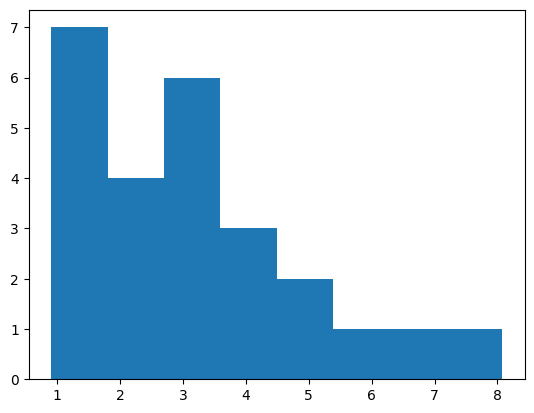

In [3]:
x = np.array([  1.00201077,  1.58251956,  0.94515919,  6.48778002,  1.47764604,
                5.18847071,  4.21988095,  2.85971522,  3.40044437,  3.74907745,
                1.18065796,  3.74748775,  3.27328568,  3.19374927,  8.0726155 ,
                0.90326139,  2.34460034,  2.14199217,  3.27446744,  3.58872357,
                1.20611533,  2.16594393,  5.56610242,  4.66479977,  2.3573932 ])
_ = plt.hist(x, bins=8)

### Fitting data to probability distributions

We start with the problem of finding values for the parameters that provide the best fit between the model and the data, called point estimates. First, we need to define what we mean by ‘best fit’. There are two commonly used criteria:

* **Method of moments** chooses the parameters so that the sample moments (typically the sample mean and variance) match the theoretical moments of our chosen distribution.
* **Maximum likelihood** chooses the parameters to maximize the likelihood, which measures how likely it is to observe our given sample.

### Discrete Random Variables

$$X = \{0,1\}$$

$$Y = \{\ldots,-2,-1,0,1,2,\ldots\}$$

**Probability Mass Function**: 

For discrete $X$,

$$Pr(X=x) = f(x|\theta)$$

![Discrete variable](http://upload.wikimedia.org/wikipedia/commons/1/16/Poisson_pmf.svg)

***e.g. Poisson distribution***

The Poisson distribution models unbounded counts:
<!-- 
<div style="font-size: 150%;">   -->
$$Pr(X=x)=\frac{e^{-\lambda}\lambda^x}{x!}$$
<!-- </div> -->

* $X=\{0,1,2,\ldots\}$
* $\lambda > 0$

$$E(X) = \text{Var}(X) = \lambda$$

### Continuous Random Variables

$$X \in [0,1]$$

$$Y \in (-\infty, \infty)$$

**Probability Density Function**: 

For continuous $X$,

$$Pr(x \le X \le x + dx) = f(x|\theta)dx \, \text{ as } \, dx \rightarrow 0$$

![Continuous variable](http://upload.wikimedia.org/wikipedia/commons/e/ec/Exponential_pdf.svg)

***e.g. normal distribution***

<!-- <div style="font-size: 150%;">   -->
$$f(x) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[-\frac{(x-\mu)^2}{2\sigma^2}\right]$$
<!-- </div> -->

* $X \in \mathbf{R}$
* $\mu \in \mathbf{R}$
* $\sigma>0$

$$\begin{align}E(X) &= \mu \cr
\text{Var}(X) &= \sigma^2 \end{align}$$

### Example: Nashville Precipitation

The dataset `nashville_precip.txt` contains [NOAA precipitation data for Nashville measured since 1871](https://www.weather.gov/ohx/otherrecords). The gamma distribution is often a good fit to aggregated rainfall data, and will be our candidate distribution in this case.

In [4]:
precip = pd.read_table("nashville_precip.txt", index_col=0, na_values='NA', delim_whitespace=True)
precip.head()

C:\Users\Ilia\AppData\Local\Temp\ipykernel_22632\3090127304.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  precip = pd.read_table("nashville_precip.txt", index_col=0, na_values='NA', delim_whitespace=True)


       Jan   Feb   Mar    Apr   May   Jun   Jul   Aug   Sep   Oct   Nov   Dec
Year                                                                         
1871  2.76  4.58  5.01   4.13  3.30  2.98  1.58  2.36  0.95  1.31  2.13  1.65
1872  2.32  2.11  3.14   5.91  3.09  5.17  6.10  1.65  4.50  1.58  2.25  2.38
1873  2.96  7.14  4.11   3.59  6.31  4.20  4.63  2.36  1.81  4.28  4.36  5.94
1874  5.22  9.23  5.36  11.84  1.49  2.87  2.65  3.52  3.12  2.63  6.12  4.19
1875  6.15  3.06  8.14   4.22  1.73  5.63  8.12  1.60  3.79  1.25  5.46  4.30

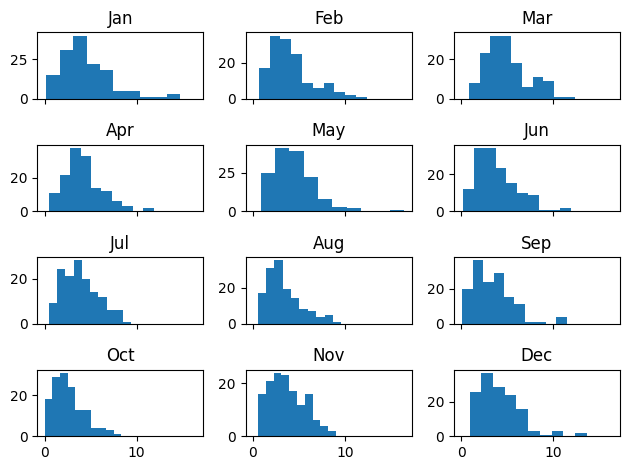

In [5]:
_ = precip.hist(sharex=True, sharey=False, grid=False)
plt.tight_layout()

The first step is recognixing what sort of distribution to fit our data to. A couple of observations:

1. The data are skewed, with a longer tail to the right than to the left
2. The data are positive-valued, since they are measuring rainfall
3. The data are continuous

There are a few possible choices, but one suitable alternative is the **gamma distribution**:

<!-- <div style="font-size: 150%;">   -->
$$x \sim \text{Gamma}(\alpha, \beta) = \frac{\beta^{\alpha}x^{\alpha-1}e^{-\beta x}}{\Gamma(\alpha)}$$
<!-- </div> -->

![gamma](http://upload.wikimedia.org/wikipedia/commons/thumb/e/e6/Gamma_distribution_pdf.svg/500px-Gamma_distribution_pdf.svg.png)

The ***method of moments*** simply assigns the empirical mean and variance to their theoretical counterparts, so that we can solve for the parameters.

So, for the gamma distribution, the mean and variance are:
<!-- 
<div style="font-size: 150%;">   -->
$$ \hat{\mu} = \bar{X} = \alpha \beta $$
$$ \hat{\sigma}^2 = S^2 = \alpha \beta^2 $$
<!-- </div> -->

So, if we solve for these parameters, we can use a gamma distribution to describe our data:

<!-- <div style="font-size: 150%;">   -->
$$ \alpha = \frac{\bar{X}^2}{S^2}, \, \beta = \frac{S^2}{\bar{X}} $$
<!-- </div> -->

Let's deal with the missing value in the October data. Given what we are trying to do, it is most sensible to fill in the missing value with the average of the available values.

In [6]:
precip.fillna(value={'Oct': precip.Oct.mean()}, inplace=True)

Now, let's calculate the sample moments of interest, the means and variances by month:

In [7]:
precip_mean = precip.mean()
precip_mean

Jan    4.523688
Feb    4.097801
Mar    4.977589
Apr    4.204468
May    4.325674
Jun    3.873475
Jul    3.895461
Aug    3.367305
Sep    3.377660
Oct    2.610500
Nov    3.685887
Dec    4.176241
dtype: float64

In [8]:
precip_var = precip.var()
precip_var

Jan    6.928862
Feb    5.516660
Mar    5.365444
Apr    4.117096
May    5.306409
Jun    5.033206
Jul    3.777012
Aug    3.779876
Sep    4.940099
Oct    2.741659
Nov    3.679274
Dec    5.418022
dtype: float64

We then use these moments to estimate $\alpha$ and $\beta$ for each month:

In [9]:
alpha_mom = precip_mean ** 2 / precip_var
beta_mom = precip_var / precip_mean

In [10]:
alpha_mom, beta_mom

(Jan    2.953407
 Feb    3.043866
 Mar    4.617770
 Apr    4.293694
 May    3.526199
 Jun    2.980965
 Jul    4.017624
 Aug    2.999766
 Sep    2.309383
 Oct    2.485616
 Nov    3.692511
 Dec    3.219070
 dtype: float64,
 Jan    1.531684
 Feb    1.346249
 Mar    1.077920
 Apr    0.979219
 May    1.226724
 Jun    1.299403
 Jul    0.969593
 Aug    1.122522
 Sep    1.462581
 Oct    1.050243
 Nov    0.998206
 Dec    1.297344
 dtype: float64)

We can use the `gamma.pdf` function in `scipy.stats.distributions` to plot the ditribtuions implied by the calculated alphas and betas. For example, here is January:

C:\Users\Ilia\AppData\Local\Temp\ipykernel_22632\3880124149.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(np.linspace(0, 10), gamma.pdf(np.linspace(0, 10), alpha_mom[0], beta_mom[0]))


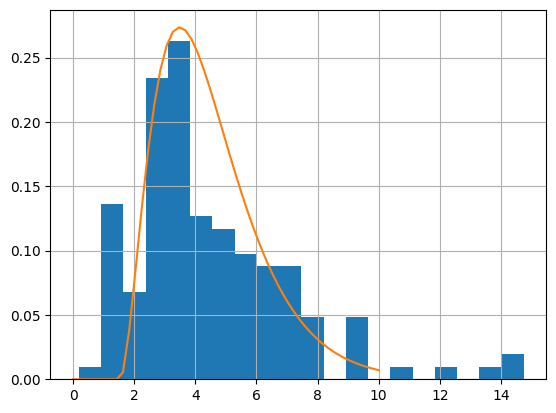

In [11]:
from scipy.stats.distributions import gamma

precip.Jan.hist(density=True, bins=20)
plt.plot(np.linspace(0, 10), gamma.pdf(np.linspace(0, 10), alpha_mom[0], beta_mom[0]))

Looping over all months, we can create a grid of plots for the distribution of rainfall, using the gamma distribution:

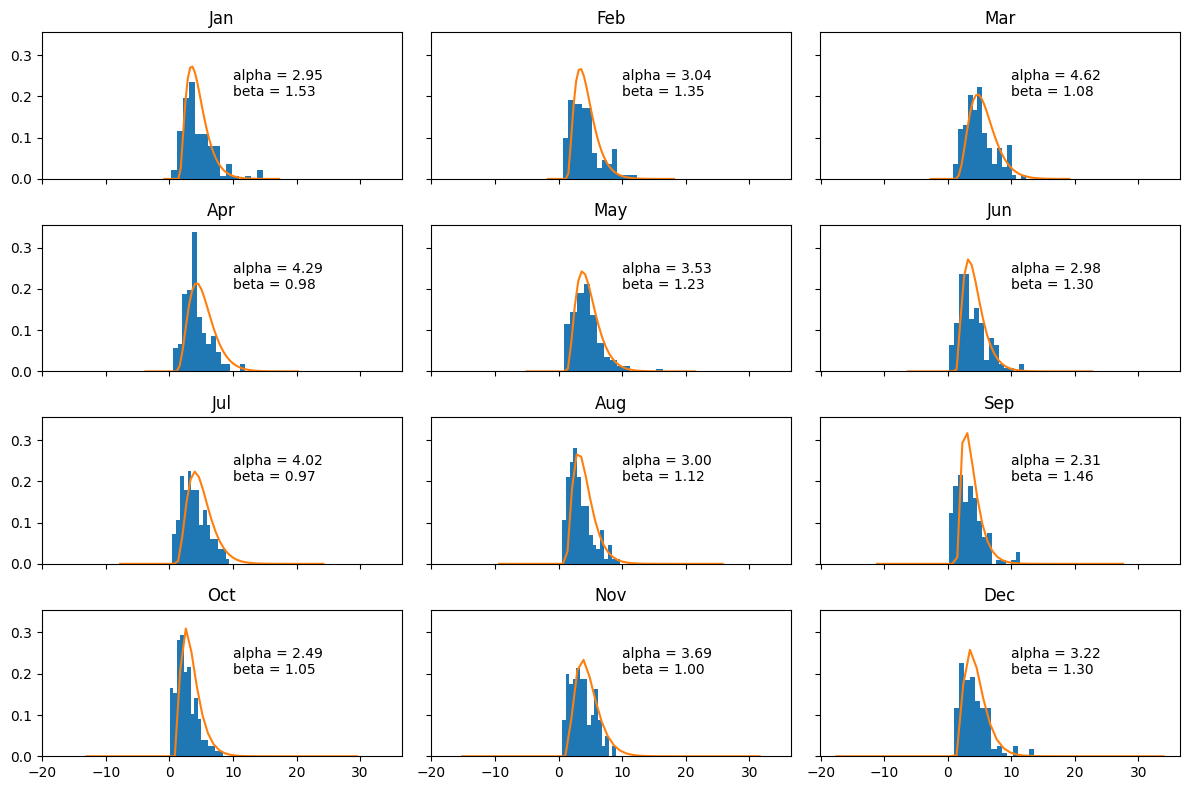

In [12]:
axs = precip.hist(density=True, figsize=(12, 8), sharex=True, sharey=True, bins=15, grid=False)

for ax in axs.ravel():
    
    # Get month
    m = ax.get_title()
    
    # Plot fitted distribution
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, gamma.pdf(x, alpha_mom[m], beta_mom[m]))
    
    # Annotate with parameter estimates
    label = 'alpha = {0:.2f}\nbeta = {1:.2f}'.format(alpha_mom[m], beta_mom[m])
    ax.annotate(label, xy=(10, 0.2))
    
plt.tight_layout()

Maximum Likelihood
==================

**Maximum likelihood** (ML) fitting is usually more work than the method of moments, but it is preferred as the resulting estimator is known to have good theoretical properties. 

There is a ton of theory regarding ML. We will restrict ourselves to the mechanics here.

Say we have some data $y = y_1,y_2,\ldots,y_n$ that is distributed according to some distribution:

<!-- <div style="font-size: 120%;">   -->
$$Pr(Y_i=y_i | \theta)$$
<!-- </div> -->

Here, for example, is a **Poisson distribution** that describes the distribution of some discrete variables, typically *counts*: 

Text(0, 0.5, 'Pr(y)')

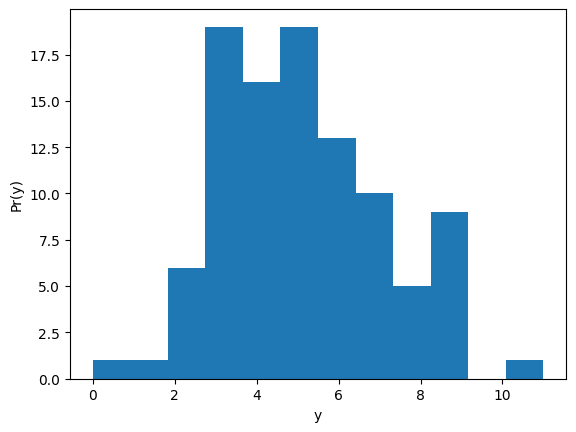

In [14]:
y = np.random.poisson(5, size=100)
plt.hist(y, bins=12)
plt.xlabel('y'); plt.ylabel('Pr(y)')

The product $\prod_{i=1}^n Pr(y_i | \theta)$ gives us a measure of how **likely** it is to observe values $y_1,\ldots,y_n$ given the parameters $\theta$. Maximum likelihood fitting consists of choosing the appropriate function $l= Pr(Y|\theta)$ to maximize for a given set of observations. We call this function the *likelihood function*, because it is a measure of how likely the observations are if the model is true.

> Given these data, how likely is this model?

In the above model, the data were drawn from a Poisson distribution with parameter $\lambda =5$.

$$L(y|\lambda=5) = \frac{e^{-5} 5^y}{y!}$$

So, for any given value of $y$, we can calculate its likelihood:

In [15]:
poisson_like = lambda x, lam: np.exp(-lam) * (lam**x) / (np.arange(x)+1).prod()

lam = 6
value = 10
poisson_like(value, lam)

np.float64(0.041303093412337726)

In [16]:
np.sum(poisson_like(yi, lam) for yi in y)

C:\Users\Ilia\AppData\Local\Temp\ipykernel_22632\99816479.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(poisson_like(yi, lam) for yi in y)


np.float64(11.797239192625145)

In [17]:
lam = 8
np.sum(poisson_like(yi, lam) for yi in y)

C:\Users\Ilia\AppData\Local\Temp\ipykernel_22632\3181754033.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(poisson_like(yi, lam) for yi in y)


np.float64(8.06611795090091)

We can plot the likelihood function for any value of the parameter(s):

<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Ilia\AppData\Local\Temp\ipykernel_22632\69969966.py:4: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$')
C:\Users\Ilia\AppData\Local\Temp\ipykernel_22632\69969966.py:5: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('L($\lambda$|x={0})'.format(x))


Text(0, 0.5, 'L($\\lambda$|x=5)')

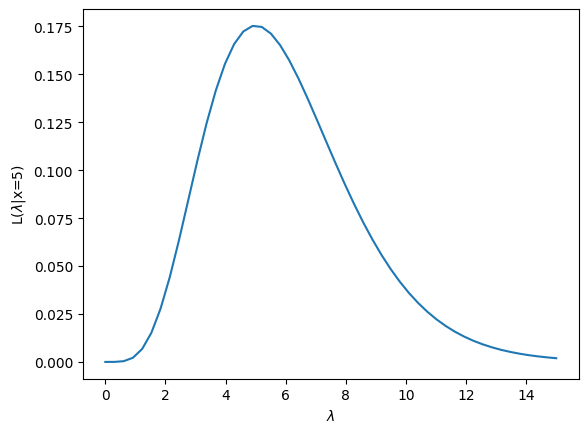

In [19]:
lambdas = np.linspace(0,15)
x = 5
plt.plot(lambdas, [poisson_like(x, l) for l in lambdas])
plt.xlabel('$\lambda$')
plt.ylabel('L($\lambda$|x={0})'.format(x))

How is the likelihood function different than the probability distribution function (PDF)? The likelihood is a function of the parameter(s) *given the data*, whereas the PDF returns the probability of data given a particular parameter value. Here is the PDF of the Poisson for $\lambda=5$.

<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Ilia\AppData\Local\Temp\ipykernel_22632\1305543120.py:5: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('Pr(X|$\lambda$=5)')


Text(0, 0.5, 'Pr(X|$\\lambda$=5)')

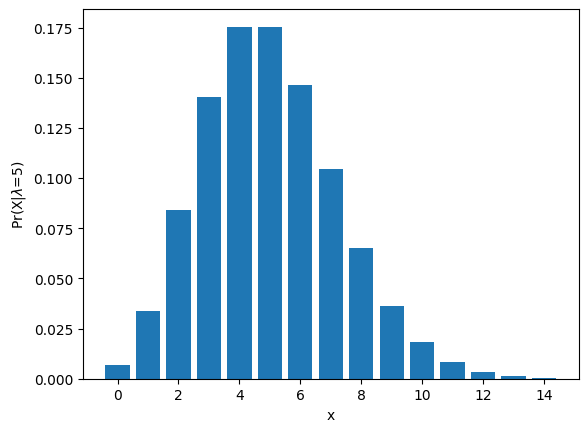

In [20]:
lam = 5
xvals = np.arange(15)
plt.bar(xvals, [poisson_like(x, lam) for x in xvals])
plt.xlabel('x')
plt.ylabel('Pr(X|$\lambda$=5)')

Why are we interested in the likelihood function? 

A reasonable estimate of the true, unknown value for the parameter is one which **maximizes the likelihood function**. So, inference is reduced to an optimization problem.

Going back to the rainfall data, if we are using a gamma distribution we need to maximize:

$$\begin{align}l(\alpha,\beta) &= \sum_{i=1}^n \log[\beta^{\alpha} x^{\alpha-1} e^{-x/\beta}\Gamma(\alpha)^{-1}] \cr 
&= n[(\alpha-1)\overline{\log(x)} - \bar{x}\beta + \alpha\log(\beta) - \log\Gamma(\alpha)]\end{align}$$

(*Its usually easier to work in the log scale*)

where $n = 2012 − 1871 = 141$ and the bar indicates an average over all *i*. We choose $\alpha$ and $\beta$ to maximize $l(\alpha,\beta)$.

Notice $l$ is infinite if any $x$ is zero. We do not have any zeros, but we do have an NA value for one of the October data, which we dealt with above.

### Finding the MLE

To find the maximum of any function, we typically take the *derivative* with respect to the variable to be maximized, set it to zero and solve for that variable. 

$$\frac{\partial l(\alpha,\beta)}{\partial \beta} = n\left(\frac{\alpha}{\beta} - \bar{x}\right) = 0$$

Which can be solved as $\beta = \alpha/\bar{x}$. However, plugging this into the derivative with respect to $\alpha$ yields:

$$\frac{\partial l(\alpha,\beta)}{\partial \alpha} = \log(\alpha) + \overline{\log(x)} - \log(\bar{x}) - \frac{\Gamma(\alpha)'}{\Gamma(\alpha)} = 0$$

This has no closed form solution. We must use ***numerical optimization***!

Numerical optimization alogarithms take an initial "guess" at the solution, and iteratively improve the guess until it gets "close enough" to the answer.

Here, we will use Newton-Raphson algorithm:

<!-- <div style="font-size: 120%;">   -->
$$x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}$$
<!-- </div> -->

Which is available to us via SciPy:

In [21]:
from scipy.optimize import newton

Here is a graphical example of how Newtone-Raphson converges on a solution, using an arbitrary function:

Text(1.4706070287539936, -0.2, '$x_{n+1}$')

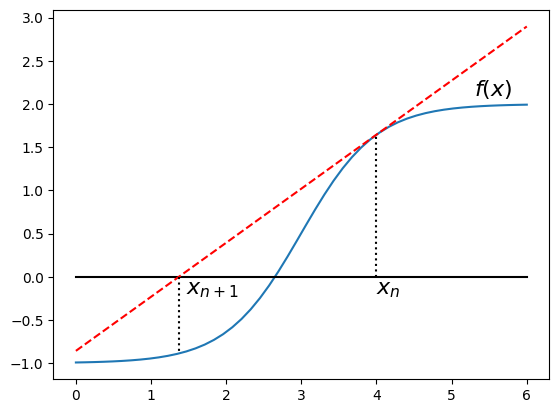

In [22]:
# some function
func = lambda x: 3./(1 + 400*np.exp(-2*x)) - 1
xvals = np.linspace(0, 6)
plt.plot(xvals, func(xvals))
plt.text(5.3, 2.1, '$f(x)$', fontsize=16)
# zero line
plt.plot([0,6], [0,0], 'k-')
# value at step n
plt.plot([4,4], [0,func(4)], 'k:')
plt.text(4, -.2, '$x_n$', fontsize=16)
# tangent line
tanline = lambda x: -0.858 + 0.626*x
plt.plot(xvals, tanline(xvals), 'r--')
# point at step n+1
xprime = 0.858/0.626
plt.plot([xprime, xprime], [tanline(xprime), func(xprime)], 'k:')
plt.text(xprime+.1, -.2, '$x_{n+1}$', fontsize=16)

To apply the Newton-Raphson algorithm, we need a function that returns a vector containing the **first and second derivatives** of the function with respect to the variable of interest. In our case, this is:

In [23]:
from scipy.special import psi, polygamma

dlgamma = lambda m, log_mean, mean_log: np.log(m) - psi(m) - log_mean + mean_log
dl2gamma = lambda m, *args: 1./m - polygamma(1, m)

where `log_mean` and `mean_log` are $\log{\bar{x}}$ and $\overline{\log(x)}$, respectively. `psi` and `polygamma` are complex functions of the Gamma function that result when you take first and second derivatives of that function.

In [24]:
# Calculate statistics
log_mean = precip.mean().apply(np.log)
mean_log = precip.apply(np.log).mean()

Time to optimize!

In [25]:
# Alpha MLE for December
alpha_mle = newton(dlgamma, 2, dl2gamma, args=(log_mean[-1], mean_log[-1]))
alpha_mle

C:\Users\Ilia\AppData\Local\Temp\ipykernel_22632\3875982210.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_mle = newton(dlgamma, 2, dl2gamma, args=(log_mean[-1], mean_log[-1]))


np.float64(3.518967915239979)

And now plug this back into the solution for beta:

<!-- <div style="font-size: 120%;">   -->
$$ \beta  = \frac{\alpha}{\bar{X}} $$
<!-- </div> -->

In [26]:
beta_mle = alpha_mle/precip.mean()[-1]
beta_mle

C:\Users\Ilia\AppData\Local\Temp\ipykernel_22632\1173534368.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta_mle = alpha_mle/precip.mean()[-1]


np.float64(0.842616075484142)

We can compare the fit of the estimates derived from MLE to those from the method of moments:

C:\Users\Ilia\AppData\Local\Temp\ipykernel_22632\1862015118.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(x, gamma.pdf(x, alpha_mom[-1], beta_mom[-1]), 'm-')


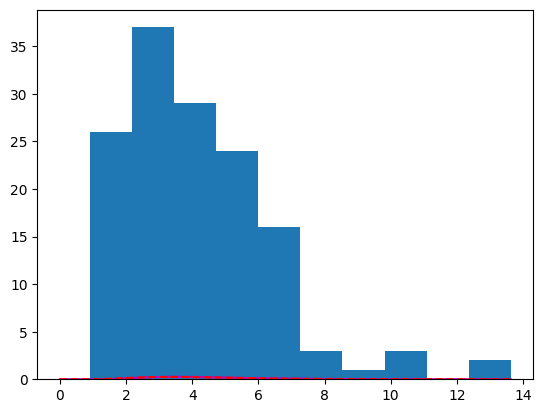

In [30]:
dec = precip.Dec
dec.hist(bins=10, grid=False)
x = np.linspace(0, dec.max())
plt.plot(x, gamma.pdf(x, alpha_mom[-1], beta_mom[-1]), 'm-')
plt.plot(x, gamma.pdf(x, alpha_mle, beta_mle), 'r--')

For some common distributions, SciPy includes methods for fitting via MLE:

In [31]:
from scipy.stats import gamma

gamma.fit(precip.Dec)

(np.float64(2.242751775315231),
 np.float64(0.6549460447018862),
 np.float64(1.570073932063466))

## MAP estimation

In [32]:
# known distribution
mu = 5
sigma = 2

X = np.random.normal(mu, sigma, [1000,1]) 

theta = 5.0574


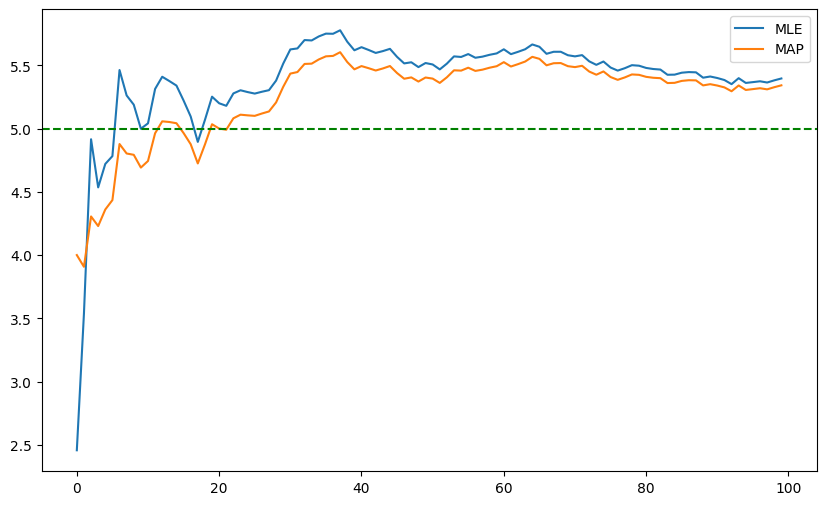

In [33]:
#prior distribution
mu_prior = 4
theta = np.random.normal(mu_prior,1)
m = 100
XMLE = []
XMAP = []

for k in range(m):
    xmle = np.mean(X[0:k+1,0])
    xmap = k/(k+sigma**2)*xmle + sigma**2/(k + sigma**2)*mu_prior
    XMLE.append(xmle)
    XMAP.append(xmap)
    
print('theta = {:.4f}'.format(theta))
plt.figure(figsize=(10,6))
plt.plot(XMLE)
plt.plot(XMAP)
plt.axhline(y = mu, color = 'g', linestyle = '--')
plt.legend(['MLE','MAP'])
plt.show()

0.17116498873870215
0.11866968423788028


C:\Users\Ilia\AppData\Local\Temp\ipykernel_22632\2195973873.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(XMLE, kde=True, label='MLE')


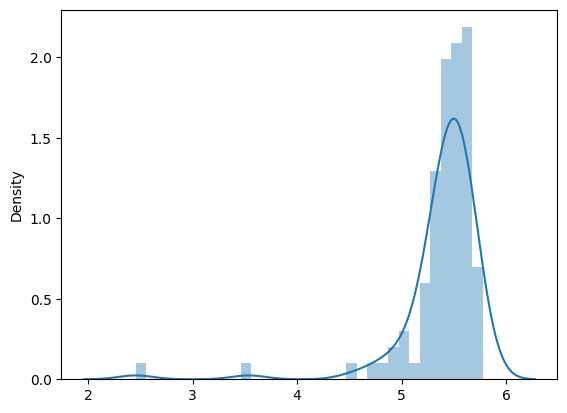

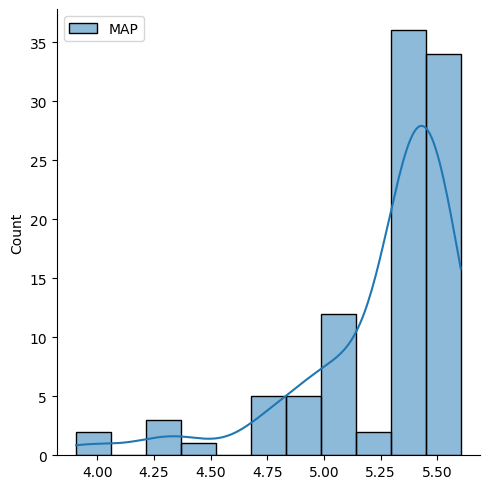

In [34]:
import seaborn as sns

sns.distplot(XMLE, kde=True, label='MLE')
print(np.var(XMLE))
sns.displot(XMAP, kde=True,label='MAP')
print(np.var(XMAP))
plt.legend()

theta = 0.1377


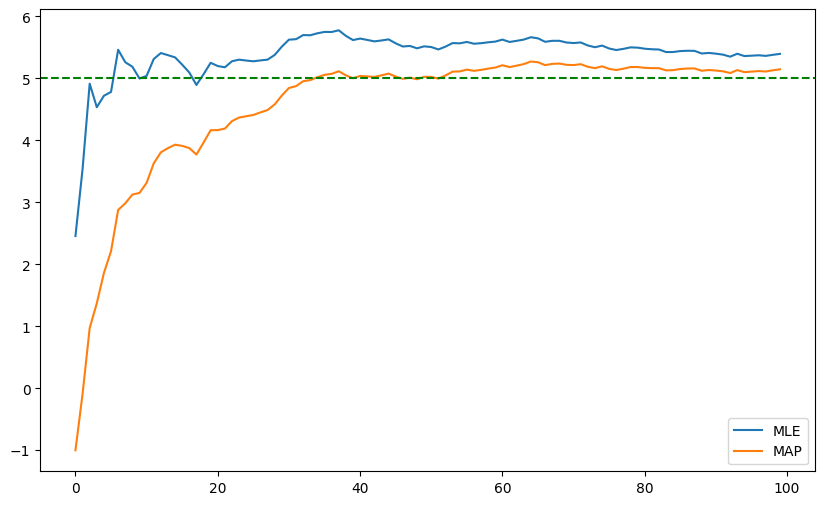

In [35]:
# Плохое предположение об априорном распределении
mu_prior = -1
theta = np.random.normal(mu_prior,1)
m = 100
XMLE = []
XMAP = []

for k in range(m):
    xmle = np.mean(X[0:k+1,0])
    xmap = k/(k+sigma**2)*xmle + sigma**2/(k + sigma**2)*mu_prior
    XMLE.append(xmle)
    XMAP.append(xmap)
    
print('theta = {:.4f}'.format(theta))
plt.figure(figsize=(10,6))
plt.plot(XMLE)
plt.plot(XMAP)
plt.axhline(y = mu, color = 'g', linestyle = '--')
plt.legend(['MLE','MAP'])
plt.show()

0.17116498873870215
1.261436430078636


C:\Users\Ilia\AppData\Local\Temp\ipykernel_22632\653834757.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(XMLE, kde=True)


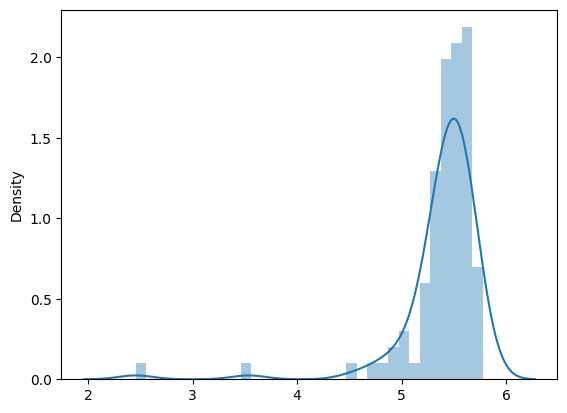

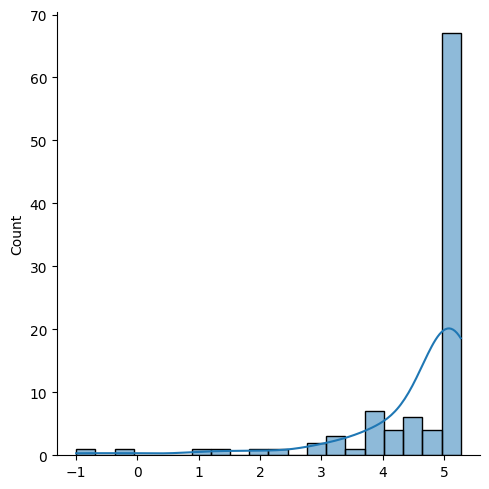

In [36]:
import seaborn as sns

sns.distplot(XMLE, kde=True)
print(np.var(XMLE))
sns.displot(XMAP, kde=True)
print(np.var(XMAP))

This fit is not directly comparable to our estimates, however, because SciPy's `gamma.fit` method fits an odd 3-parameter version of the gamma distribution.

### Kernel density estimates

In some instances, we may not be interested in the parameters of a particular distribution of data, but just a smoothed representation of the data at hand. In this case, we can estimate the disribution *non-parametrically* (i.e. making no assumptions about the form of the underlying distribution) using kernel density estimation.

In [37]:
# Some random data
y = np.random.random(50) * 10
y

array([4.491161  , 7.02866558, 6.23336348, 2.63457488, 9.40646901,
       0.88453138, 4.19599847, 1.31871797, 3.76679662, 6.90139706,
       7.52066274, 8.00116211, 3.60354107, 7.10089056, 8.94779591,
       4.47990117, 8.18793556, 6.48198332, 4.80028699, 9.04440118,
       7.48744969, 1.69149276, 9.31962062, 4.70990121, 4.2710385 ,
       5.86321496, 7.51408901, 4.11069134, 1.40785981, 3.23072349,
       5.02058605, 4.58554496, 6.2124604 , 3.63620138, 4.17730022,
       2.19663432, 5.30501312, 4.28330424, 8.57045684, 2.71066153,
       0.92040085, 2.77375773, 4.08286905, 1.94289349, 9.37739604,
       0.91424668, 4.63473027, 2.2169443 , 7.68585306, 1.03599834])

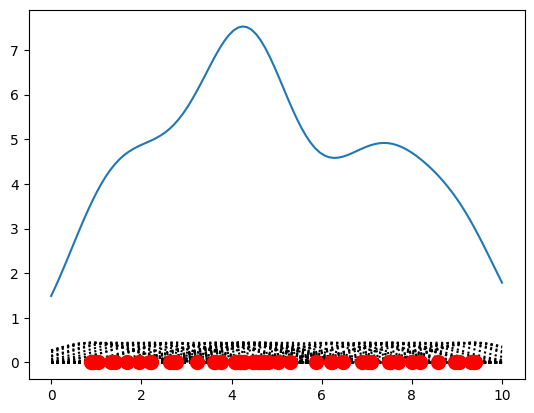

In [38]:
x = np.linspace(0, 10, 100)
# Smoothing parameter
s = 0.9
# Calculate the kernels
kernels = np.transpose([norm.pdf(x, yi, s) for yi in y])
plt.plot(x, kernels, 'k:')
plt.plot(x, kernels.sum(1))
plt.plot(y, np.zeros(len(y)), 'ro', ms=10)

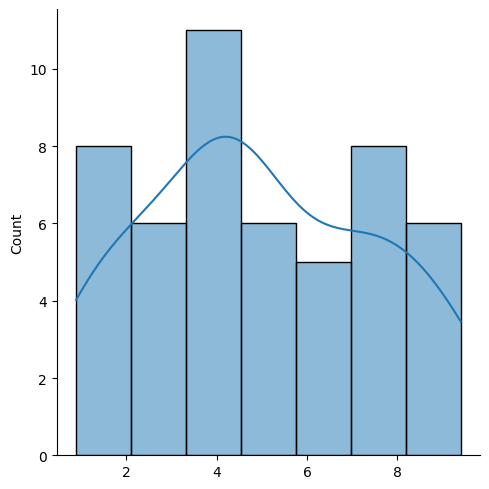

In [39]:
import seaborn as sns
sns.displot(y, kde=True)

SciPy implements a Gaussian KDE that automatically chooses an appropriate bandwidth. Let's create a bi-modal distribution of data that is not easily summarized by a parametric distribution:

In [40]:
# Create a bi-modal distribution with a mixture of Normals.
x1 = np.random.normal(0, 3, 50)
x2 = np.random.normal(4, 1, 50)

# Append by row
x = np.r_[x1, x2]

(array([ 2.,  6.,  9., 13., 12., 23., 29.,  6.]),
 array([-6.18399651, -4.54752068, -2.91104485, -1.27456901,  0.36190682,
         1.99838265,  3.63485849,  5.27133432,  6.90781015]),
 <BarContainer object of 8 artists>)

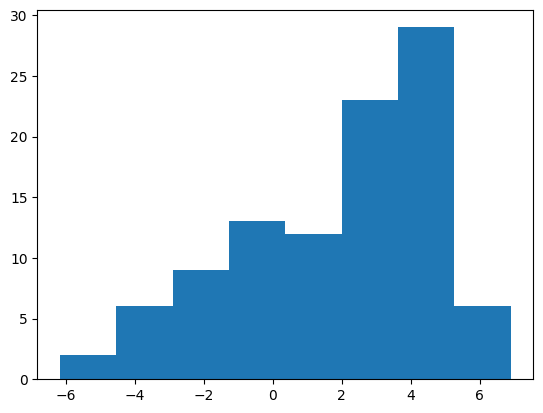

In [42]:
plt.hist(x, bins=8)

C:\Users\Ilia\AppData\Local\Temp\ipykernel_22632\53493917.py:3: DeprecationWarning: Please import `gaussian_kde` from the `scipy.stats` namespace; the `scipy.stats.kde` namespace is deprecated and will be removed in SciPy 2.0.0.
  density = kde.gaussian_kde(x)


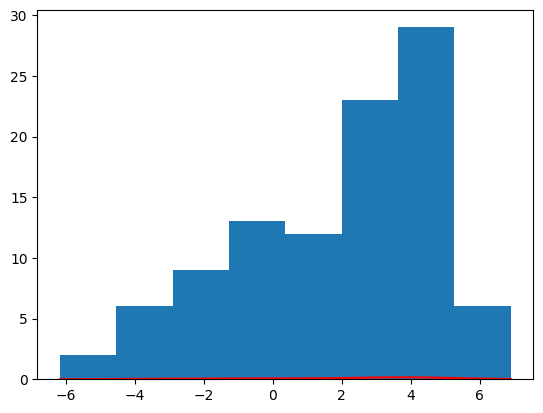

In [44]:
from scipy.stats import kde

density = kde.gaussian_kde(x)
xgrid = np.linspace(x.min(), x.max(), 100)
plt.hist(x, bins=8)
plt.plot(xgrid, density(xgrid), 'r-')